In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.activations import relu,softmax
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
def data_generator(embeddings, labels, batch_size, epochs, type): #embeddings, labels type list
  epoch_steps = int(embeddings.shape[0]/batch_size)
  steps = epoch_steps * epochs
  iterration = 0
  for i in range(steps):
    iterration = i%epoch_steps #step_in_epoch
    start = iterration*batch_size
    end = start + batch_size - 1 
    x = embeddings[start:end,:].toarray()
    y = np.array(labels[start:end])
    #print("yielding "+type)
    yield (x,y)

def print_and_plot_history(history):
  print('val_acc: ',max(history.history['val_categorical_accuracy']))
  print('val_loss: ',min(history.history['val_loss']))
  print('train_acc: ',max(history.history['categorical_accuracy']))
  print('train_loss: ',min(history.history['loss']))
  print("train/val loss ratio: ", min(history.history['loss'])/min(history.history['val_loss']))

  plt.semilogy(history.history['loss'])
  plt.semilogy(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

def convert_int_to_class(num):
  if num == 0:
    return "positive"
  elif num == 1:
    return "neutral"
  else:
    return "negative"

In [ ]:
batch_size = 128
epochs = 40
dropout = 0.2

In [ ]:
tfidf_corpus = pickle.load(open("/content/drive/MyDrive/data/corpus_pickle.p", "rb"))
tfidf_vectorized_corpus = tfidf_corpus['vectorized_corpus']

file = open('/content/drive/MyDrive/data/australia_tweets6.txt')
csvreader = pd.read_csv(file, sep='<delimiter>')
print(csvreader.groupby(["sentiment"]).count())
csvreader.loc[csvreader['sentiment'] == 'very positive', 'sentiment'] = 'positive'
csvreader.loc[csvreader['sentiment'] == 'very negative', 'sentiment'] = 'negative'
print(csvreader.groupby(["sentiment"]).count())
y = csvreader['sentiment']

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


                  tweeter_id   text
sentiment                          
negative               82423  82423
neutral or mixed       24334  24334
positive               36263  36263
very negative           5396   5396
very positive            770    770
                  tweeter_id   text
sentiment                          
negative               87819  87819
neutral or mixed       24334  24334
positive               37033  37033


In [ ]:

#train test split 0.3
train_x, val_x, train_y, val_y = model_selection.train_test_split(tfidf_vectorized_corpus, y, stratify = y, test_size=0.3, random_state=100)

#one hot encoding
ohe = OneHotEncoder()
train_y_copy = train_y.copy()
val_y_copy = val_y.copy()
train_y = pd.DataFrame(train_y)
train_y_one_hot = ohe.fit_transform(train_y.values.reshape(-1, 1)).toarray()
val_y = pd.DataFrame(val_y)
val_y_one_hot = ohe.fit_transform(val_y.values.reshape(-1, 1)).toarray()

In [ ]:
#print(test_y_one_hot.shape)
print(val_y_one_hot[0]) #[0 0 1] positive
print(val_y_copy[0])
print(val_y_one_hot[1]) #[1 0 0] negative
print(val_y_copy[2])
#print(test_y_one_hot[3])
#print(test_y_copy[12])
#print(y)
#[0 1 0] neutral

[0. 0. 1.]
positive
[1. 0. 0.]
negative



*   37.033 positive (test = 11.110, train = 25.923 )
*   87.819 negative (test = 26.346, train = 61.473)
*   24.334 neutral (test = 7300, train = 17.034)

In [ ]:
val_positive = [[x,y,z] for x,y,z in val_y_one_hot if z == 1]
val_negative = [[x,y,z] for x,y,z in val_y_one_hot if x == 1]
val_neutral = [[x,y,z] for x,y,z in val_y_one_hot if y == 1]
print(len(val_positive)) #11110
print(len(val_negative)) #26346
print(len(val_neutral)) #7300
train_positive = [[x,y,z] for x,y,z in train_y_one_hot if z == 1]
train_negative = [[x,y,z] for x,y,z in train_y_one_hot if x == 1]
train_neutral = [[x,y,z] for x,y,z in train_y_one_hot if y == 1]
print(len(train_positive)) #25923
print(len(train_negative)) #61473
print(len(train_neutral)) #17034

11110
26346
7300
25923
61473
17034


In [ ]:
type(train_x)
train_x[:2,:]
train_y_one_hot[:2]

array([[0., 0., 1.],
       [1., 0., 0.]])

# ModelV5 larger 

In [ ]:

modelv5l = Sequential()
modelv5l.add(Dense(256, input_dim=65000, activation='relu')) #768 for CLS token
#modelv5.add(BatchNormalization())
modelv5l.add(Dropout(0.2))
modelv5l.add(Dense(600, activation='relu'))
#modelv5.add(BatchNormalization())
modelv5l.add(Dropout(0.2))
modelv5l.add(Dense(600, activation='relu'))
#modelv5.add(BatchNormalization())
modelv5l.add(Dropout(0.2))
modelv5l.add(Dense(600, activation='relu'))
#modelv5.add(BatchNormalization())
modelv5l.add(Dropout(0.2))
modelv5l.add(Dense(3, activation='softmax'))


train_generator = data_generator(train_x, train_y_one_hot, batch_size, epochs, "train")
validation_generator = data_generator(val_x, val_y_one_hot, batch_size, epochs, "validation")

from keras.callbacks import ModelCheckpoint, EarlyStopping
directory_path = '/content/drive/MyDrive/models'
filepath = directory_path + '/tfidf_mlp/mlpv5l'+str(epochs)+'_epochs_'+str(batch_size)+"_batch_"

checkpointer = ModelCheckpoint(filepath=filepath+"{epoch:02d}-{val_categorical_accuracy:.3f}."+"hdf5",
                               verbose=1,
                               save_best_only=True,  
                               monitor='val_categorical_accuracy',
                               mode = 'max')
earlystopper = EarlyStopping(monitor='val_categorical_accuracy',
                              patience=10,
                              mode='max',
                              restore_best_weights=True)
modelv5l.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

train_steps = int(train_x.shape[0]/batch_size)
val_steps = int(val_x.shape[0]/batch_size)


In [ ]:
'''
historyv5l = modelv5l.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    callbacks = [earlystopper], #checkpointer removed
                    validation_data = validation_generator,
                    validation_steps = val_steps
                    )
'''
historyv5l = modelv5l.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    callbacks = [earlystopper], #checkpointer removed
                    validation_data = validation_generator,
                    validation_steps = val_steps,
                    class_weight={
                        0:40,
                        1:61,
                        2:17
                    }
                    )

Epoch 1/40
815/815 [==============================] - 256s 311ms/step - loss: 27.7549 - categorical_accuracy: 0.6463 - val_loss: 0.7718 - val_categorical_accuracy: 0.6714
Epoch 2/40
815/815 [==============================] - 252s 309ms/step - loss: 20.6196 - categorical_accuracy: 0.7460 - val_loss: 0.8837 - val_categorical_accuracy: 0.6645
Epoch 3/40
815/815 [==============================] - 250s 307ms/step - loss: 12.3223 - categorical_accuracy: 0.8530 - val_loss: 1.1101 - val_categorical_accuracy: 0.6593
Epoch 4/40
815/815 [==============================] - 249s 306ms/step - loss: 7.5536 - categorical_accuracy: 0.9139 - val_loss: 1.3850 - val_categorical_accuracy: 0.6547
Epoch 5/40
815/815 [==============================] - 250s 307ms/step - loss: 4.7137 - categorical_accuracy: 0.9474 - val_loss: 1.4795 - val_categorical_accuracy: 0.6557
Epoch 6/40
815/815 [==============================] - 253s 310ms/step - loss: 3.3892 - categorical_accuracy: 0.9626 - val_loss: 1.7196 - val_catego

val_acc:  0.6851296424865723
val_loss:  0.7717783451080322
train_acc:  0.9906574487686157
train_loss:  0.849251925945282
train/val loss ratio:  1.1003832011202712


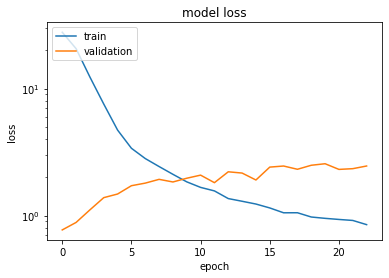

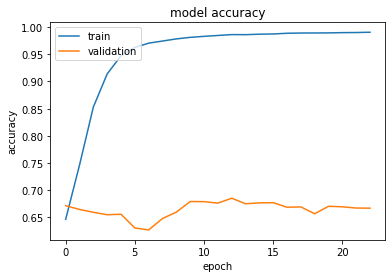

In [ ]:
print_and_plot_history(historyv5l)

In [ ]:
val_X = np.array(val_x)
val_Y = np.array(val_y)
val_pred_v5l = modelv5l.predict(val_X, batch_size=batch_size, verbose=1)

Y_pred_v5l=np.argmax(val_pred_v5l, axis=1) # [0,1,2]
Y_pred_v5l_string = [convert_int_to_class(num) for num in Y_pred_v5l] #[positive, negative, neutral]
Y_val_v5l=np.argmax(val_Y, axis=1) #[0,1,2]
Y_val_v5l_string = [convert_int_to_class(num) for num in Y_val_v5l] #[positive, negative, neutral]

report_v5l = classification_report(Y_val_v5l_string, Y_pred_v5l_string)
matrix_v5l = confusion_matrix(Y_val_v5l_string, Y_pred_v5l_string)

print(report_v5l)

ax = plt.subplot()
sns.heatmap(matrix_v5l, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive']); ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive']);

ValueError: ignored

# ModelV5 smaller

In [ ]:

modelv5s = Sequential()
modelv5s.add(Dense(256, input_dim=65000, activation='relu')) #768 for CLS token
#modelv5.add(BatchNormalization())
modelv5s.add(Dropout(0.2))
modelv5s.add(Dense(600, activation='relu'))
#modelv5.add(BatchNormalization())
modelv5s.add(Dropout(0.2))
modelv5s.add(Dense(600, activation='relu'))
#modelv5.add(BatchNormalization())
modelv5s.add(Dropout(0.2))
modelv5s.add(Dense(600, activation='relu'))
#modelv5.add(BatchNormalization())
modelv5s.add(Dropout(0.2))
modelv5s.add(Dense(3, activation='softmax'))


train_generator = data_generator(train_x, train_y_one_hot, batch_size, epochs, "train")
validation_generator = data_generator(val_x, val_y_one_hot, batch_size, epochs, "validation")

from keras.callbacks import ModelCheckpoint, EarlyStopping
directory_path = '/content/drive/MyDrive/models'
filepath = directory_path + '/tfidf_mlp/mlpv5s'+str(epochs)+'_epochs_'+str(batch_size)+"_batch_"

checkpointer = ModelCheckpoint(filepath=filepath+"{epoch:02d}-{val_categorical_accuracy:.3f}."+"hdf5",
                               verbose=1,
                               save_best_only=True,  
                               monitor='val_categorical_accuracy',
                               mode = 'max')
earlystopper = EarlyStopping(monitor='val_categorical_accuracy',
                              patience=10,
                              mode='max',
                              restore_best_weights=True)
modelv5s.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

train_steps = int(len(train_x)/batch_size)
val_steps = int(len(val_x)/batch_size)


In [ ]:
'''
historyv5s = modelv5s.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    callbacks = [earlystopper], #checkpointer removed
                    validation_data = validation_generator,
                    validation_steps = val_steps
                    )
'''
historyv5s = modelv5s.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    callbacks = [earlystopper], #checkpointer removed
                    validation_data = validation_generator,
                    validation_steps = val_steps,
                    class_weight={
                        0:40,
                        1:61,
                        2:17
                    }
                    )

In [ ]:
print_and_plot_history(historyv5s)

In [ ]:
val_X = np.array(val_x)
val_Y = np.array(val_y)
val_pred_v5s = modelv5s.predict(val_X, batch_size=batch_size, verbose=1)

Y_pred_v5s=np.argmax(val_pred_v5s, axis=1) # [0,1,2]
Y_pred_v5s_string = [convert_int_to_class(num) for num in Y_pred_v5s] #[positive, negative, neutral]
Y_val_v5s=np.argmax(val_Y, axis=1) #[0,1,2]
Y_val_v5s_string = [convert_int_to_class(num) for num in Y_val_v5s] #[positive, negative, neutral]

report_v5s = classification_report(Y_val_v5s_string, Y_pred_v5s_string)
matrix_v5s = confusion_matrix(Y_val_v5s_string, Y_pred_v5s_string)

print(report_v5s)

ax = plt.subplot()
sns.heatmap(matrix_v5s, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive']); ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive']);

# Smaller model

In [ ]:
#smaller model
modelv0 = Sequential()
modelv0.add(Dense(256, input_dim=65000, activation='relu')) #768 for CLS token
modelv0.add(Dropout(dropout))
modelv0.add(Dense(300, activation='relu'))
modelv0.add(Dropout(dropout))
modelv0.add(Dense(3, activation='softmax'))

train_generator = data_generator(train_x, train_y_one_hot, batch_size, epochs, "train")
validation_generator = data_generator(val_x, val_y_one_hot, batch_size, epochs, "validation")

from keras.callbacks import ModelCheckpoint, EarlyStopping
directory_path = '/content/drive/MyDrive/models/tfidf_mpl/modelv0_'
filepath = directory_path +str(epochs)+'_epochs_'+str(batch_size)+"_batch_" + str(dropout)+"_dropout_"

checkpointer = ModelCheckpoint(filepath=filepath+"{epoch:02d}-{val_categorical_accuracy:.3f}."+"hdf5",
                               verbose=1,
                               save_best_only=True,  
                               monitor='val_categorical_accuracy',
                               mode = 'max')
earlystopper = EarlyStopping(monitor='val_categorical_accuracy',
                              patience=10,
                              mode='max',
                              restore_best_weights=True)

modelv0.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
train_steps = int(len(train_x)/batch_size)
val_steps = int(len(val_x)/batch_size)



In [ ]:
'''
historyv0 = modelv0.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    callbacks = [earlystopper], #checkpointer removed
                    validation_data = validation_generator,
                    validation_steps = val_steps,
                    class_weight={
                        0:40,
                        1:61,
                        2:17
                    }
                    )
'''

historyv0 = modelv0.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    callbacks = [earlystopper], #checkpointer removed
                    validation_data = validation_generator,
                    validation_steps = val_steps,
                    class_weight={
                        0:40,
                        1:61,
                        2:17
                    }
                    )

In [ ]:
print_and_plot_history(historyv0)

In [ ]:
val_X = np.array(val_x)
val_Y = np.array(val_y)
val_pred_v0 = modelv0.predict(val_X, batch_size=batch_size, verbose=1)

Y_pred_v0=np.argmax(val_pred_v0, axis=1) # [0,1,2]
Y_pred_v0_string = [convert_int_to_class(num) for num in Y_pred_v0] #[positive, negative, neutral]
Y_val_v0=np.argmax(val_Y, axis=1) #[0,1,2]
Y_val_v0_string = [convert_int_to_class(num) for num in Y_val_v0] #[positive, negative, neutral]

report_v0 = classification_report(Y_val_v0_string, Y_pred_v0_string)
matrix_v0 = confusion_matrix(Y_val_v0_string, Y_pred_v0_string)

print(report_v0)

ax = plt.subplot()
sns.heatmap(matrix_v0, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive']); ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive']);